# 实验4 使用多项式特征扩展实现Logistic回归的非线性分类

【目标任务】：芯片质量预测——根据芯片的两项测试成绩预测芯片是否通过测试赛，从分布上看，是一个非线性可分问题。

【实验目的】：
 
    1、实现多项式特征构造，了解欠拟合和过拟合
    2、实现正则化的Logistic回归算法，了解通过正则化一定程度解决过拟合
    3、实现正则化的损失函数和梯度计算
    4、掌握调试技术

In [837]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op

## 1. 准备数据
### 1.1 读取数据

In [838]:
data = np.loadtxt('./ex7data.txt', delimiter=',')
label = data[:, 2]

### 1.2 可视化数据——绘制散点图

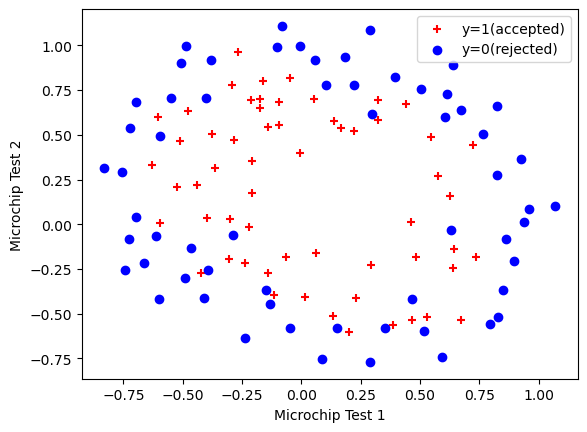

In [839]:
pos = data[label == 1,0:2]
neg = data[label == 0,0:2]

plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')
lgd_pos = plt.scatter(pos[:,0], pos[:,1], marker='+', c='red')
lgd_neg = plt.scatter(neg[:,0], neg[:,1], marker='o', c='blue')
plt.legend(handles=[lgd_pos, lgd_neg], labels=['y=1(accepted)', 'y=0(rejected)'], loc='best')
plt.show()

### 1.3 使用多项式特征

注意，mapFeature中完成了常数项的添加（第一列1)

In [840]:
#完成函数mapFeature，输入特征值x1,x2后，返回一个数组,该数组存储维度扩增后的特征值，特征最高次为6次
#将X的前两列分别作为参数X1,X2传入mapFeatrure，并用变量x接收完成构造的特征值数组
#X的尺寸应为(28,118)
def mapFeature(X1,X2):
    degree = 6 # 每个Featuer的最高次
    out = np.ones((1,X1.size))
    for i in range(1, degree + 1):
        for j in range(i + 1):
            term = (X1 ** (i - j)) * (X2 ** j)
            out = np.vstack((out, term.reshape(1, -1))) 
    return out

X = mapFeature(data[:,[0]].T, data[:,[1]].T)
y = data[:, [2]].T
print(f"X.shape{X.shape}")


X.shape(28, 118)


## 2 训练用于非线性可分的Logistic回归模型
初始化模型参数w、正则化系数lambda(缩写成lbd)

In [841]:
#初始化w数组,参数w由scipy.optimize.minimize()要求为一维数据
#初始化正则化参数lbd为1
n, m = X.shape
print('n=', n, 'm=', m)
w = np.zeros(n)
lbd = 1

n= 28 m= 118


### 2.1 定义Sigmoid函数、带正则项的代价函数costFunction()

In [842]:
def sigmoid(z):
    g = 1/(1+np.exp(-1*z))
    return g

#完成正则化的损失函数costFunction(),返回值为一维数组
def costFunction(w, X, y, lbd):
    w = w[:, np.newaxis]
    fx = sigmoid(w.T @ X)
    m = X.shape[1] 
    cost = np.sum((-y*np.log(fx)-(1-y)*np.log(1-fx)))/m+(lbd/(2.0*m))*np.sum(w**2)
    return cost.flatten()

print('对初始零向量w求得的cost为',costFunction(w, X, y, lbd))
w = np.ones(n)
print('对初始全一w求得的cost为',costFunction(w, X, y, lbd))

对初始零向量w求得的cost为 [0.69314718]
对初始全一w求得的cost为 [2.1390856]


### 2.2 计算梯度

In [843]:
def gradient(w, X, y, lbd):
    w = w[:, np.newaxis]
    fx = sigmoid(X.T @ w)
    grad = (X @ (fx - y.T)) / m + lbd * w / m
    return grad.flatten() # 为scipy.optimize.minimize()返回一维数组

w = np.zeros(n)
grad = gradient(w, X, y, lbd)
print('对初始零向量w求得的gradient为', grad)
w = np.ones(n)
grad = gradient(w, X, y, lbd)
print('对初始全一w求得的gradient为',grad)

对初始零向量w求得的gradient为 [8.47457627e-03 1.87880932e-02 7.77711864e-05 5.03446395e-02
 1.15013308e-02 3.76648474e-02 1.83559872e-02 7.32393391e-03
 8.19244468e-03 2.34764889e-02 3.93486234e-02 2.23923907e-03
 1.28600503e-02 3.09593720e-03 3.93028171e-02 1.99707467e-02
 4.32983232e-03 3.38643902e-03 5.83822078e-03 4.47629067e-03
 3.10079849e-02 3.10312442e-02 1.09740238e-03 6.31570797e-03
 4.08503006e-04 7.26504316e-03 1.37646175e-03 3.87936363e-02]
对初始全一w求得的gradient为 [0.35451965 0.08508073 0.11852457 0.1505916  0.01591449 0.16811439
 0.06712094 0.03217053 0.02604321 0.10719727 0.09725885 0.01098433
 0.04195657 0.00957212 0.12367776 0.05895534 0.01870409 0.01729323
 0.02352665 0.01513039 0.09858123 0.07328323 0.01051447 0.02270567
 0.00904832 0.02563548 0.00823079 0.10601204]


### 2.3 使用共轭梯度法最小化带正则项的损失函数，求对应的w

scipy.optimize.minimize方法对参数维度要求严格，参数x0与jac的返回值类型必须为一维数组，否则会报错。可使用 flatten() 将多维数组折叠成一维数组的副本

首先确认参数维度是否正确 grad, w.flatten(), X ,y.flatten()

In [844]:
# 确认参数维度是否正确 grad, w.flatten(), X ,y.flatten()
print(np.shape(grad),np.shape(w.flatten()),np.shape(X),np.shape(y.flatten()))

(28,) (28,) (28, 118) (118,)


In [845]:
w = np.zeros((n, 1))
result = op.minimize(fun=costFunction, x0=w.flatten(), args=(X, y, lbd), method='CG', jac=gradient)
print(result)
min_w = result.x[:, np.newaxis].flatten()
print(min_w)

     fun: 0.5351602541409695
     jac: array([ 2.20086670e-07, -1.70093482e-06, -5.68363516e-06, -4.17135375e-06,
        5.97002980e-06, -2.10822319e-06, -1.86846612e-06, -1.31492314e-06,
       -2.70889681e-07, -4.99179614e-07, -3.58881938e-06, -1.34843001e-06,
       -1.61959583e-06,  1.57189206e-06, -1.04387135e-06, -2.02244337e-06,
       -9.67251440e-07, -1.70299008e-06, -1.12267440e-07,  4.66496951e-07,
       -2.37539440e-06, -3.74695014e-06, -1.38973652e-06, -8.27256012e-07,
       -1.03923842e-06, -5.35899499e-07,  4.76294085e-07, -3.20439242e-06])
 message: 'Optimization terminated successfully.'
    nfev: 59
     nit: 20
    njev: 59
  status: 0
 success: True
       x: array([ 1.1422266 ,  0.60133262,  1.16704491, -1.87184549, -0.91530674,
       -1.26956018,  0.126668  , -0.36878573, -0.34528112, -0.17358168,
       -1.42399329, -0.04879156, -0.60651133, -0.26925627, -1.16308888,
       -0.24316378, -0.20714934, -0.04338032, -0.28025341, -0.28696345,
       -0.46919527, -

### 2.4 使用模型进行预测

In [846]:
#用变量x_ext存储扩展后的X
#用pred_m存储数据的个数，分为pred_m=1和pred_m>1的情况
#用pred_rslt存储预测后的情况
def predict(w, x):
    x_ext = mapFeature(x[0, :], x[1, :])
    fx = w.T @ x_ext
    pred_m = x.shape[1]
    if pred_m == 1 :
        if fx > 0:
            return 1
        else:
            return 0
        
    if pred_m > 1 :
        pred_rslt = np.zeros((1, pred_m))
        for i in range(0,pred_m):
            if fx[i] >= 0:
                pred_rslt[0,i] = 1
            else:
                pred_rslt[0,i] = 0

    return pred_rslt

chipTest = np.array([[0, 0.6]]).T
predRslt = predict(min_w, chipTest)
print(predRslt)

1


### 2.5 绘制边界曲线

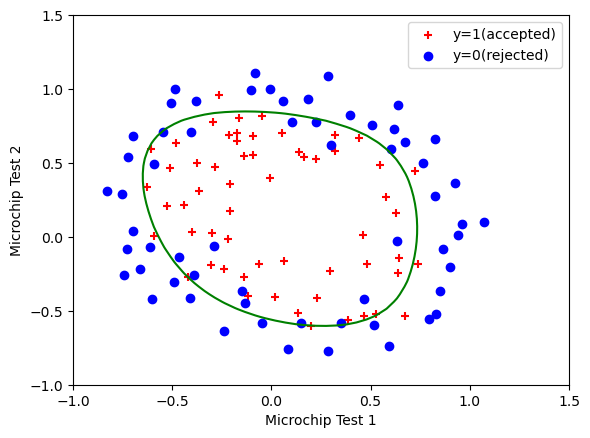

In [847]:
# 1. 绘制所有样本
plt.xlabel('Microchip Test 1')
plt.ylabel('Microchip Test 2')

lgd_pos = plt.scatter(pos[:,0], pos[:,1], marker='+', c='red')
lgd_neg = plt.scatter(neg[:,0], neg[:,1], marker='o', c='blue')
plt.legend(handles=[lgd_pos, lgd_neg], labels=['y=1(accepted)', 'y=0(rejected)'], loc='best')

# 2. 用等高线绘制
plot_x = np.linspace(-1, 1.5, 50)
plot_y = np.linspace(-1, 1.5, 50)
boundary = np.zeros((plot_x.size,plot_x.size))

for i in range(plot_x.size):
    for j in range(plot_y.size):
        boundary[i][j] = np.dot(mapFeature(plot_x[i], plot_y[j]).T, min_w)
boundary = boundary.T
plt.contour(plot_x, plot_y, boundary,[0], colors='green' )

plt.show()


### 2.6 计算模型在训练数据集上的准确率

In [848]:
pred_rslt = predict(min_w, data[:,0:2].T)
print(np.mean(pred_rslt == y))

0.8220338983050848


### 2.7  关于正则项作⽤的实验

令lambda = 0， 1 和100。然后绘制模型边界。